In [1]:
import pandas as pd
import numpy as np
import pyodbc
from quetzal.model import stepmodel
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme import expressions as ex

In [2]:
input_path = '../input/'
output_path = '../outputs/'
model_path = '../model/'

# Calibrate the demand models

## Load data

Use survey data from: „Mobilität in Städten – SrV 2018“, Stichprobe Berlin, Senatsverwaltung für Mobilität, Verkehr, Klimaschutz und Umwelt Berlin, Abtei-lung Mobilität

In [9]:
# Establish an SQL connection to data base
def get_connection(file_name):
    connection_string = (
        r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
        r"DBQ="+input_path+'transport_demand/SrV2018_B_Access/'+file_name+";"
    )
    #connection_url = sa.engine.URL.create(
    #    "access+pyodbc",
    #    query={"odbc_connect": connection_string},
    #)
    engine = pyodbc.connect(connection_string)
    #engine = sa.create_engine(connection_url)
    return engine

In [10]:
# Load data
engine = get_connection("SrV2018_Einzeldaten_Berlin_SciUse.accdb")
trip_cols = ['HHNR', 'PNR', 'WNR', 'GEWICHT_W', 'E_RVA', # general
             'V_START_LAGE', 'V_START_PLZ', 'V_ZIEL_LAGE', 'V_ZIEL_PLZ', # origin, destination
             'V_LAENGE', 'GIS_LAENGE', 'E_DAUER', 'E_GESCHW', # length, duration
             'V_ZWECK', 'V_BEGLEITUNG_OHNE', 'E_QZG_17', # purpose
             'V_UMSTIEG_ANZAHL', 'V_F_ANZAHL', # trip characteristics
             'V_VM_LAENG', 'E_HVM', 'E_HVM_4' # mode
            ]# + ['V_VM_REIHE_'+str(i) for i in range(1,9)]
trips = pd.read_sql_query(sql="select " + ", ".join(trip_cols) + " from W2018", con=engine)
persons_cols = ['HHNR', 'PNR', 'GEWICHT_P', 'E_ERW_3', 'E_ZUGANG_PKW',
                'E_MOBIL2', 'E_ANZ_WEGE2', 
                'E_OEV_FK']
persons = pd.read_sql_query(sql="select " + ", ".join(persons_cols) + " from P2018", con=engine)
codes = pd.read_sql_query(sql="select * from tblDatenkodierung", con=engine)
engine.close()

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_17544\441022540.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  trips = pd.read_sql_query(sql="select " + ", ".join(trip_cols) + " from W2018", con=engine)
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_17544\441022540.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  persons = pd.read_sql_query(sql="select " + ", ".join(persons_cols) + " from P2018", con=engine)
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_17544\441022540.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [11]:
# Number of trips by type
trips['E_RVA'].map(codes.loc[codes['Variable']=='E_RVA'].set_index('Kodierungsnr')['Kodierungstext']).value_counts()

E_RVA
Binnenverkehr               123917
Quellverkehr                  3131
Zielverkehr                   3048
Außenverkehr                  1122
Berechnung nicht möglich        16
Name: count, dtype: int64

In [12]:
# Filter
trips = trips.loc[(trips['E_RVA']==1) # within Berlin
                  & (trips['E_DAUER']!=-7) # reasonable duration
                  & (trips['V_LAENGE']>1) # reasonable distance
                  & (trips['V_LAENGE']<50) # reasonable distance
                  & (trips['E_QZG_17']!=-7) # reasonable purpose
                  & (trips['E_HVM_4']!=-7) # reasonable mode
                 ]
len(trips)

76340

<Axes: >

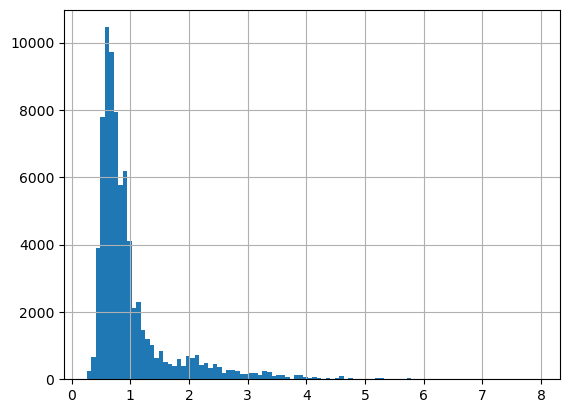

In [13]:
# trips weight distribution for population representation
trips['GEWICHT_W'].hist(bins=100)

In [14]:
# Merge person information with trips
trips['ID'] = trips['HHNR'].astype(str) + '_' + trips['PNR'].astype(str)
persons['ID'] = persons['HHNR'].astype(str) + '_' + persons['PNR'].astype(str)
persons.drop(columns=['HHNR', 'PNR'], inplace=True)
trips = trips.merge(persons, on='ID', how='left')

In [15]:
# Create mode categories
trips['mode'] = trips['E_HVM_4'] # 1: walk, 2: bicycle, 3: MIT, 4: PT
trips.loc[trips['E_HVM']==16, 'mode'] = 5 # Taxi
trips.loc[trips['E_HVM'].isin([5,8]), 'mode'] = 6 # Car sharing

In [42]:
# Filter for reasonable speeds
mode_max_speeds = {1: 10, 2: 25, 3: 60, 4: 60, 5: 60, 6: 60} #km/h
trips = trips.loc[trips['E_GESCHW']>1]
for mode, speed in mode_max_speeds.items():
    trips = trips.loc[~((trips['mode']==mode) & (trips['E_GESCHW']>speed))]
len(trips)

71024

In [17]:
# Filter for reasonable duration
trips = trips.loc[trips['E_DAUER']<200]
len(trips)

76132

In [18]:
# Drop observations that used private cars without car availability
trips = trips.loc[~((trips['E_ZUGANG_PKW']==0) & (trips['mode']==3))]
trips = trips.loc[trips['E_ZUGANG_PKW']!=-7]
len(trips)

71736

<Axes: ylabel='GEWICHT_W'>

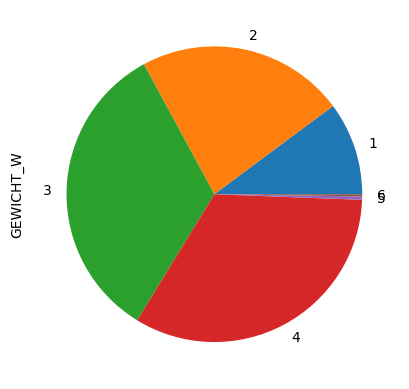

In [43]:
# Number of observations by mode
trips.groupby('mode').count()['GEWICHT_W'].plot.pie()

In [20]:
inf = 999999

## Mode choice

Calibrate a mode choice model

### Data preparation

Add level of service attributes

In [21]:
# Add price attributes based on mode-specific assumptions
# See assumptions in 05_Simulation

# non-motorised
trips['price_walk'] = 0
trips['price_bicycle'] = 0

# Motorised individual traffic
trips['price_car'] = trips['V_LAENGE'] * 0.14 # EUR/km
trips['price_taxi'] = trips['V_LAENGE'] * 2.3 + 4
trips['price_car_sharing'] = trips['E_DAUER'] * 0.15 # EUR/min
#trips['V_LAENGE'] * 1 / 1000, # Miles (EUR/km)

# Public transport
trips['price_pt'] = trips['E_OEV_FK'].map(
    {1: 3.5, 2: 10/5, 3: 49/30/4,
     60:0, 70:0, -8:3.5, -10:3.5})

In [23]:
# Load LoS table from model for travel times
sm = stepmodel.read_zippedpickles(model_path + 'los')

pt_los: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.85s/it]


In [24]:
# Assign times of modes not chosen
# Use travel time means per distance class for each mode
# because the survey does not contain explicit origins and destinations
bins = [0, 1, 2, 3, 5, 7, 10, 13, 16, 20, 25, 30, 40, 50, 60, 75]
labels = [i for i in bins[1:]]
sm.los = pd.concat([sm.pt_los, sm.car_los])
sm.los.loc[sm.los['all_walk']==True, 'length'] = sm.los.loc[sm.los['all_walk']==True, 'time'] * 5 / 3.6
sm.los = sm.los.loc[sm.los['length']>0]
sm.los.loc[sm.los['route_type']=='car', 'time'] += 2*3*60 # add parking time
sm.los.loc[sm.los['route_type'].isin(['bus', 'subway', 'tram', 'rail']), 'time'] += \
    sm.los.loc[sm.los['route_type'].isin(['bus', 'subway', 'tram', 'rail']), 'ntransfers'] * 2*60 # add transfer time
sm.los['bin'] = pd.cut(sm.los['length']/1000, bins, labels=labels)
sm.los['time'] = (sm.los['time'] / 60).astype(int)
sm.los['route_type'].replace(
    {'bike': 'bicycle', 'bus': 'pt', 'rail': 'pt', 'subway': 'pt', 'tram': 'pt'}, inplace=True)

In [40]:
# Add walking below certain distance
walk = sm.los.loc[(sm.los['route_type']=='bicycle') & (sm.los['length']<15000)].copy()
walk['route_type'] = 'walk'
walk['route_types'] = [('bike',) for i in walk.index]
walk['time'] = walk['length'] / 1000 / 5 * 60
sm.los = pd.concat([sm.los, walk]).reset_index(drop=True)

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_17544\2381292276.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sm.los.groupby(['bin', 'route_type'])['time'].mean().unstack().plot.bar(ylim=(0,120))


<Axes: xlabel='bin'>

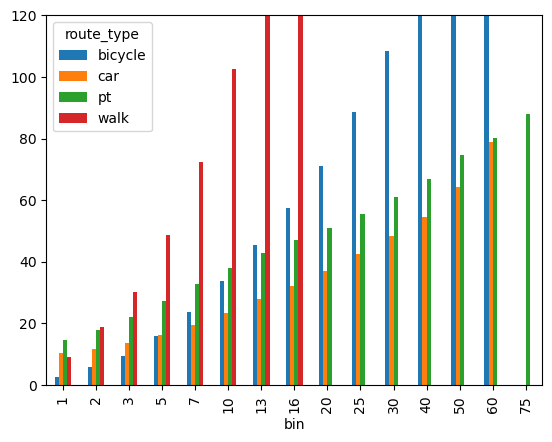

In [41]:
# Mean time distribution by mode
sm.los.groupby(['bin', 'route_type'])['time'].mean().unstack().plot.bar(ylim=(0,120))

<Axes: xlabel='bin'>

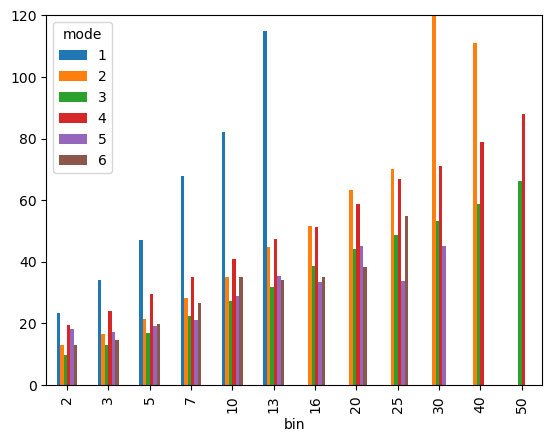

In [45]:
# In survey data
trips['bin'] = pd.cut(trips['V_LAENGE'], bins, labels=labels).astype(int)
trips.groupby(['bin', 'mode'])['E_DAUER'].mean().unstack().plot.bar(ylim=(0,120))

In [46]:
# Add time to calibration data
mode_dict = {1: 'walk', 2: 'bicycle', 3: 'car', 4: 'pt', 5: 'taxi', 6: 'car_sharing'}
time_mode_dist.index = time_mode_dist.index.astype(int)
for i, mode in mode_dict.items():
    trips['time_'+mode] = np.nan
    mask = trips['mode']==i
    # Observed time for the chosen mode
    trips.loc[mask, 'time_'+mode] = trips.loc[mask, 'E_DAUER']
    # Synthetic times for other modes
    model_mode = mode if mode in time_mode_dist.columns else 'car'
    trips.loc[~(mask), 'time_'+mode] = trips.loc[~(mask), 'bin'].map(time_mode_dist[model_mode])
    # Perform cost damping
    #trips['time_'+mode] = np.power(np.log(trips['time_'+mode]), 3)
    trips['time_'+mode] /= 60
    # Replace NaN with infinity
    trips['time_'+mode].fillna(inf, inplace=True)

In [47]:
# Generate availability columns based on time
for mode in mode_dict.values():
    trips['av_'+mode] = (trips['time_'+mode] != inf).astype(int)

### Model formulation

Use biogeme notation. Split population by car availability and PT subscription.

In [48]:
# make database columns global variables
price_cols = [c for c in trips.columns if 'price' in c]
time_cols = [c for c in trips.columns if 'time' in c]
av_cols = [c for c in trips.columns if 'av_' in c]
db_all = db.Database('all_trips', trips[['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
globals().update(db_all.variables)

In [49]:
# Estimation parameters
# ASC
asc_walk = ex.Beta('asc_walk', 0, None, None, 0)
asc_bicycle = ex.Beta('asc_bicycle', 0, None, None, 0)
asc_car = ex.Beta('asc_car', 0, None, None, 0)
asc_pt = ex.Beta('asc_pt', 0, None, None, 1)
asc_taxi = ex.Beta('asc_taxi', 0, None, None, 0)
asc_car_sharing = ex.Beta('asc_car_sharing', 0, None, None, 0)
# Beta
b_t = ex.Beta('b_t', 0, None, 0, 0)
b_p = ex.Beta('b_p', 0, None, 0, 0)

In [50]:
# Utility functions
V_walk = asc_walk + b_t * time_walk + b_p * price_walk
V_bicycle = asc_bicycle + b_t * time_bicycle + b_p * price_bicycle
V_car = asc_car + b_t * time_car + b_p * price_car
V_pt = asc_pt + b_t * time_pt + b_p * price_pt
V_taxi = asc_taxi + b_t * time_taxi + b_p * price_taxi
V_car_sharing = asc_car_sharing + b_t * time_car_sharing + b_p * price_car_sharing
V = {1: V_walk,
     2: V_bicycle,
     3: V_car,
     4: V_pt,
     5: V_taxi,
     6: V_car_sharing}

In [51]:
# Availability formulation
A = {1: av_walk,
     2: av_bicycle,
     3: av_car,
     4: av_pt,
     5: av_taxi,
     6: av_car_sharing}

### Estimation

In [52]:
# Estimation
results = []
def estimate(database, writer, name):
    print('Sample size for {}: {}'.format(name, database.getSampleSize()))
    mnl = models.loglogit(V, A, mode) # Choose utility functions and availabilities
    formulas = {'loglike': mnl, 'weight': GEWICHT_W} # give weights to the estimator
    model = bio.BIOGEME(database, formulas)
    model.generate_html = False
    model.generate_pickle = False
    model.saveIterations = False
    model.modelName = name
    results.append(model.estimate()) # Estimation
    output = results[-1].getEstimatedParameters()
    # Add results to the Excel file
    for key, val in results[-1].getGeneralStatistics().items():
        output.loc[key] = [val[0], val[1]] + ['' for i in range(len(output.columns)-2)]
    output.to_excel(writer, sheet_name=model.modelName)

In [54]:
writer = pd.ExcelWriter(input_path + 'mode_choice_estimation.xlsx')
# with car without PT abo
name = 'car_no_pt_abo'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==-1) & ~(trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)
# No car, no PT abo
name = 'no_car_no_pt_abo'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==0) & ~(trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)
# with car and pt abo
name = 'car_pt_abo'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==-1) & (trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)
# No car and pt abo
name = 'no_car_pt_abo'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==0) & (trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)

# Save results
writer.close()

File biogeme.toml has been created


Sample size for car_no_pt_abo: 29310


The sum of the weights (26279.798651938316) is different from the sample size (29310). Multiply the weights by 1.1153053487279359 to reconcile the two.
Obsolete syntax. Use generate_html instead of generateHtml
Obsolete syntax. Use generate_pickle instead of generatePickle


Sample size for no_car_no_pt_abo: 7698


The sum of the weights (8532.322300941827) is different from the sample size (7698). Multiply the weights by 0.9022162699069946 to reconcile the two.
Obsolete syntax. Use generate_html instead of generateHtml
Obsolete syntax. Use generate_pickle instead of generatePickle


Sample size for car_pt_abo: 15562


The sum of the weights (14879.201255871232) is different from the sample size (15562). Multiply the weights by 1.0458894756772874 to reconcile the two.
Obsolete syntax. Use generate_html instead of generateHtml
Obsolete syntax. Use generate_pickle instead of generatePickle


Sample size for no_car_pt_abo: 18454


The sum of the weights (22134.00579616824) is different from the sample size (18454). Multiply the weights by 0.8337397292628653 to reconcile the two.
Obsolete syntax. Use generate_html instead of generateHtml
Obsolete syntax. Use generate_pickle instead of generatePickle


AttributeError: 'OpenpyxlWriter' object has no attribute 'save'